In [3]:
import numpy as np
import astropy.units as u
from astropy.io import fits
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload

import poppy
import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import apra_pop_models
from apra_pop_models.math_module import xp, _scipy, ensure_np_array
import apra_pop_models.fresnel_2dm_34 as fresnel
import apra_pop_models.fraunhofer_2dm_34 as fraunhofer
import apra_pop_models.utils as utils
import apra_pop_models.props as props
from apra_pop_models.imshows import imshow1, imshow2, imshow3
import apra_pop_models.adefc_2dm as adefc
import apra_pop_models.efc_utils as efc_utils

from scipy.optimize import minimize



/home/brandon/code/apra-howfsc-models/apra_pop_models


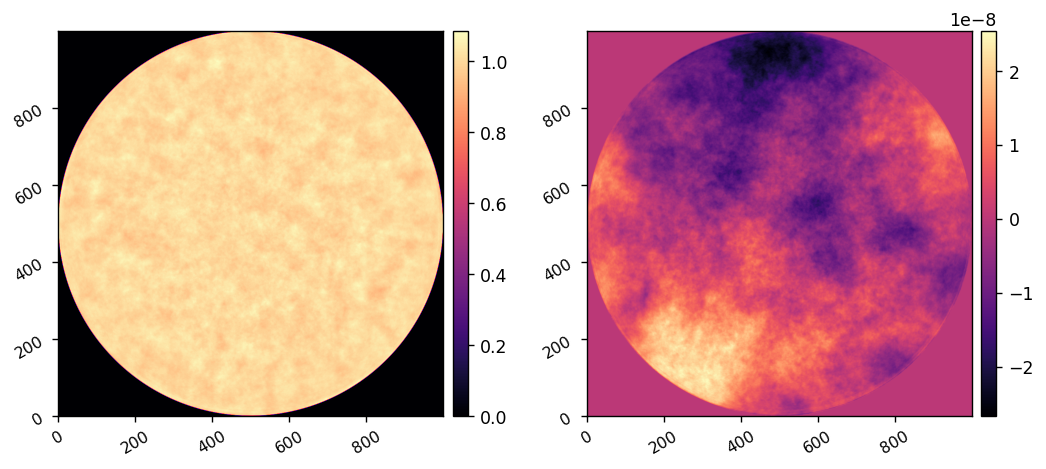

In [4]:
reload(fresnel)
I = fresnel.CORO()
I.use_opds = True

AMP, OPD = I.calc_pupil()
imshow2(AMP, OPD)

/home/brandon/code/apra-howfsc-models/apra_pop_models


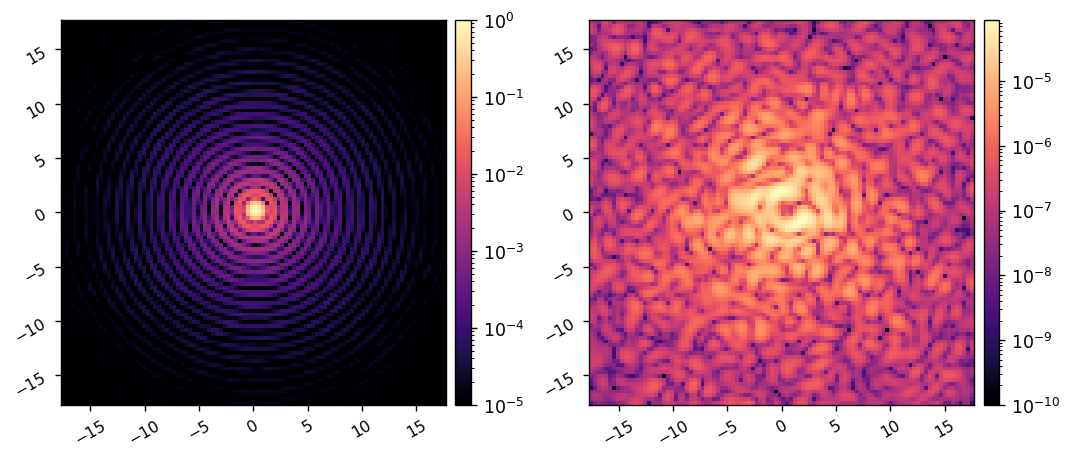

In [12]:
reload(fresnel)
I = fresnel.CORO()
I.use_opds = True

I.use_vortex = False
ref_psf = I.snap()
I.Imax_ref = xp.max(ref_psf)
ref_psf /= I.Imax_ref
I.use_vortex = True
ref_coro_im = I.snap()

imshow2(ref_psf, ref_coro_im,
        pxscl=I.psf_pixelscale_lamDc, lognorm=True, vmin1=1e-5, vmin2=1e-10)


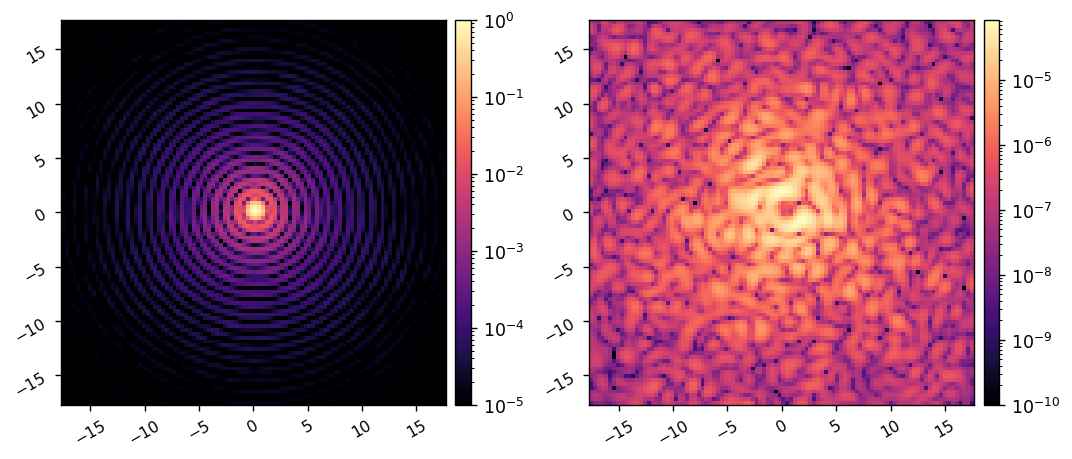

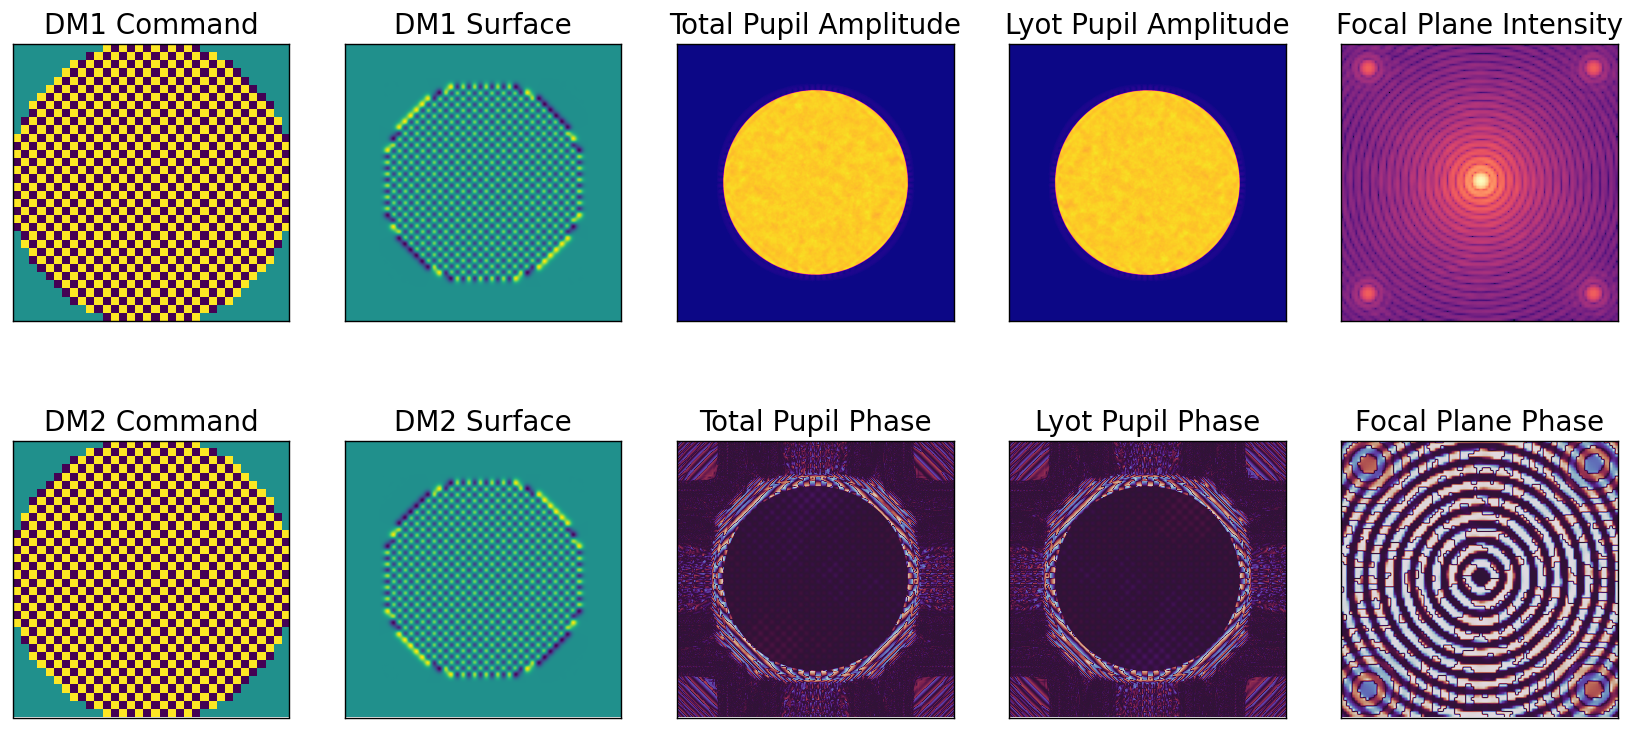

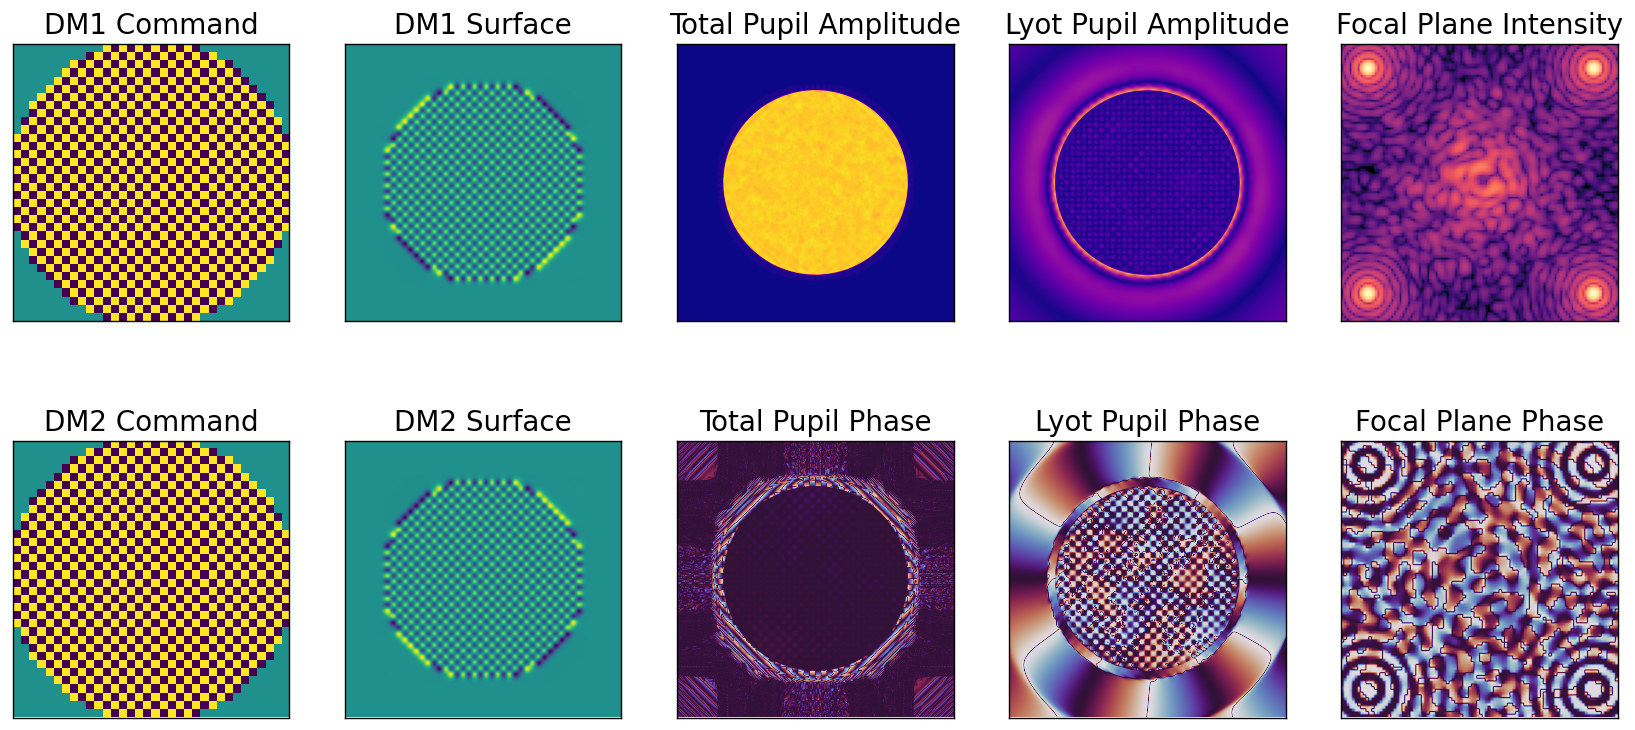

In [13]:
reload(fraunhofer)
M = fraunhofer.MODEL()
M.AMP = AMP
M.OPD = OPD

M.flip_dm = True
M.flip_lyot = True

M.setattr('use_vortex', False)
model_psf = xp.abs(M.calc_wf()[0])**2
M.setattr('Imax_ref', xp.max(model_psf))
model_psf /= M.Imax_ref

M.setattr('use_vortex', True)
model_coro_im = xp.abs(M.calc_wf()[0])**2

imshow2(model_psf, model_coro_im,
        pxscl=M.psf_pixelscale_lamDc, lognorm=True, vmin1=1e-5, vmin2=1e-10)

dm1_command, dm2_command = ( xp.zeros((M.Nact, M.Nact)), xp.zeros((M.Nact, M.Nact)) )
# command = 50e-9*utils.make_f(h=10, w=6, shift=(0,0))
dm1_command = 10e-9*utils.make_fourier_command(x_cpa=17, y_cpa=17)
dm2_command = -10e-9*utils.make_fourier_command(x_cpa=17, y_cpa=17)

acts = xp.concatenate([dm1_command[M.dm_mask], dm2_command[M.dm_mask]])
fpwf = M.forward(acts, M.wavelength_c, use_vortex=0, fancy_plot=1)
fpwf = M.forward(acts, M.wavelength_c, use_vortex=1, fancy_plot=1)

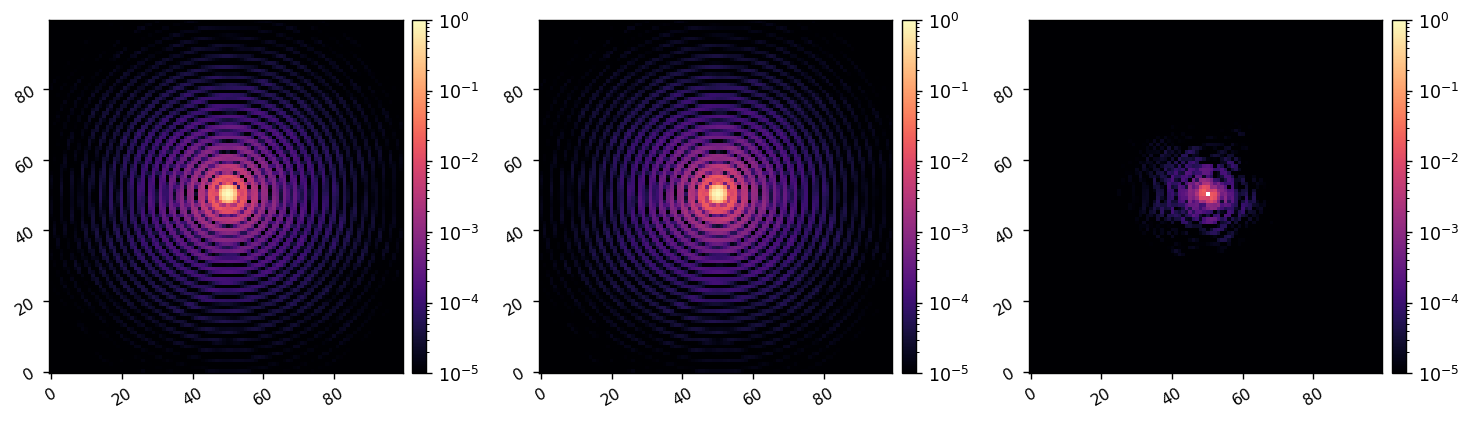

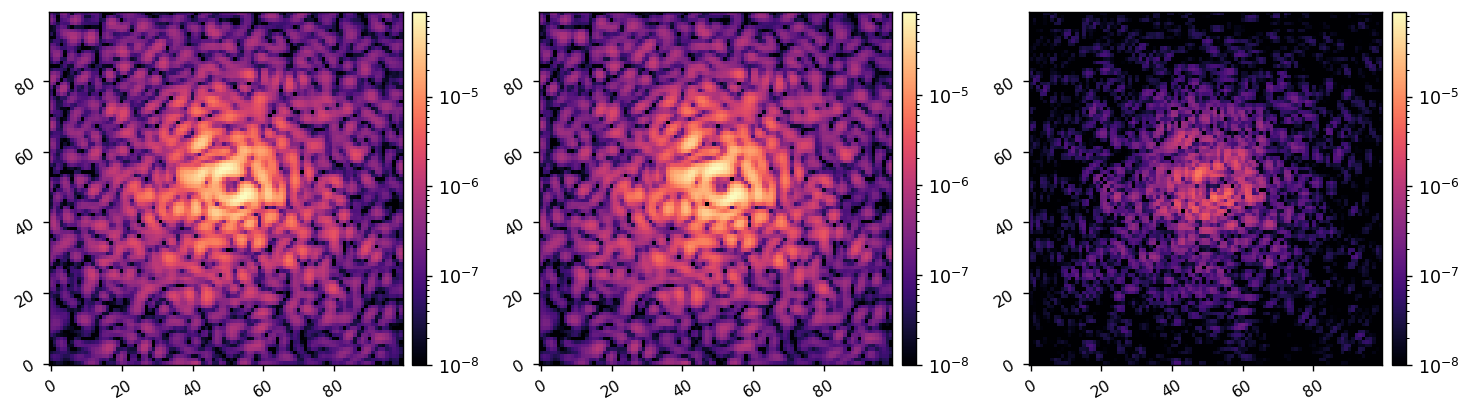

In [14]:
imshow3(ref_psf, model_psf, xp.abs(ref_psf - model_psf), 
        lognorm1=True, lognorm2=True, lognorm3=True, vmax3=1, 
        vmin1=1e-5, vmin2=1e-5, vmin3=1e-5)

imshow3(ref_coro_im, model_coro_im, xp.abs(ref_coro_im - model_coro_im), 
        lognorm1=True, lognorm2=True, lognorm3=True, vmax3=xp.max(ref_coro_im), 
        vmin1=1e-8, vmin2=1e-8, vmin3=1e-8)

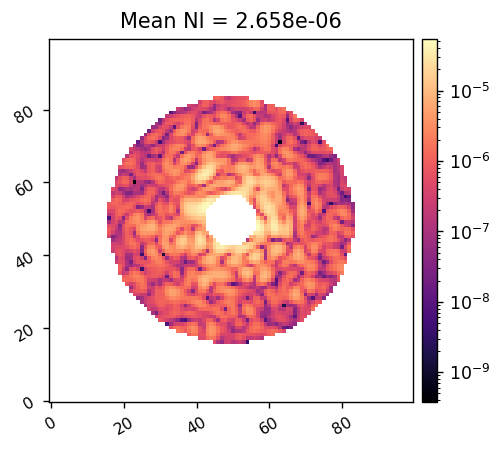

In [15]:
reload(efc_utils)
I.zero_dms()
iwa = 2.5
owa = 12
rot = 0
control_mask = efc_utils.create_annular_focal_plane_mask(I.npsf, I.psf_pixelscale_lamDc, irad=iwa, orad=owa, edge=None, rotation=rot)
mean_ni = xp.mean(ref_coro_im[control_mask])

imshow1(ref_coro_im*control_mask, f'Mean NI = {mean_ni:.3e}', lognorm=True)



	Cost-function J_delE: 0.001
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.001
	Total cost-function value: 1.000



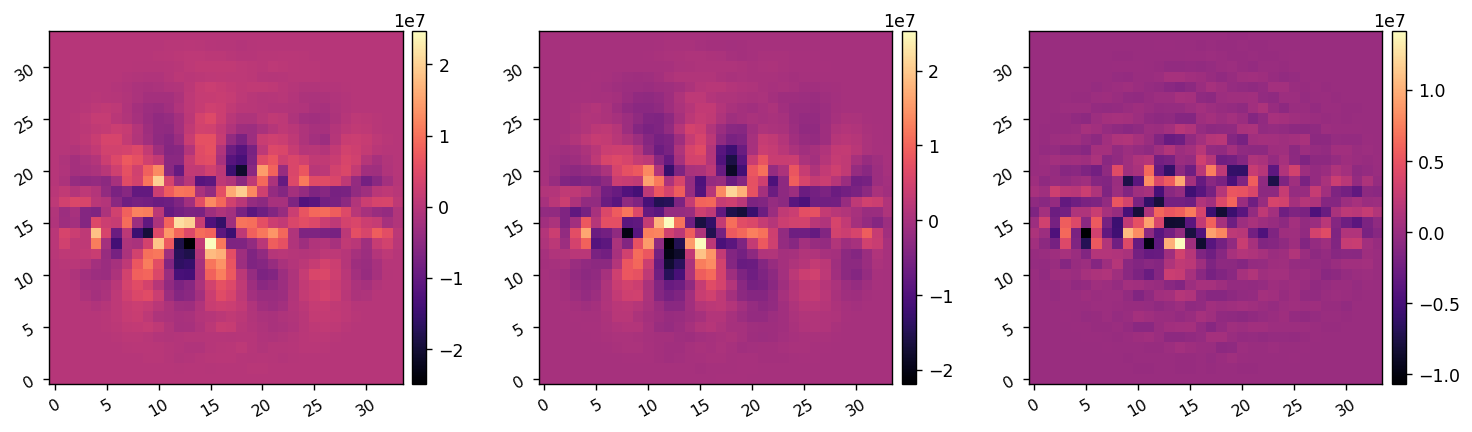

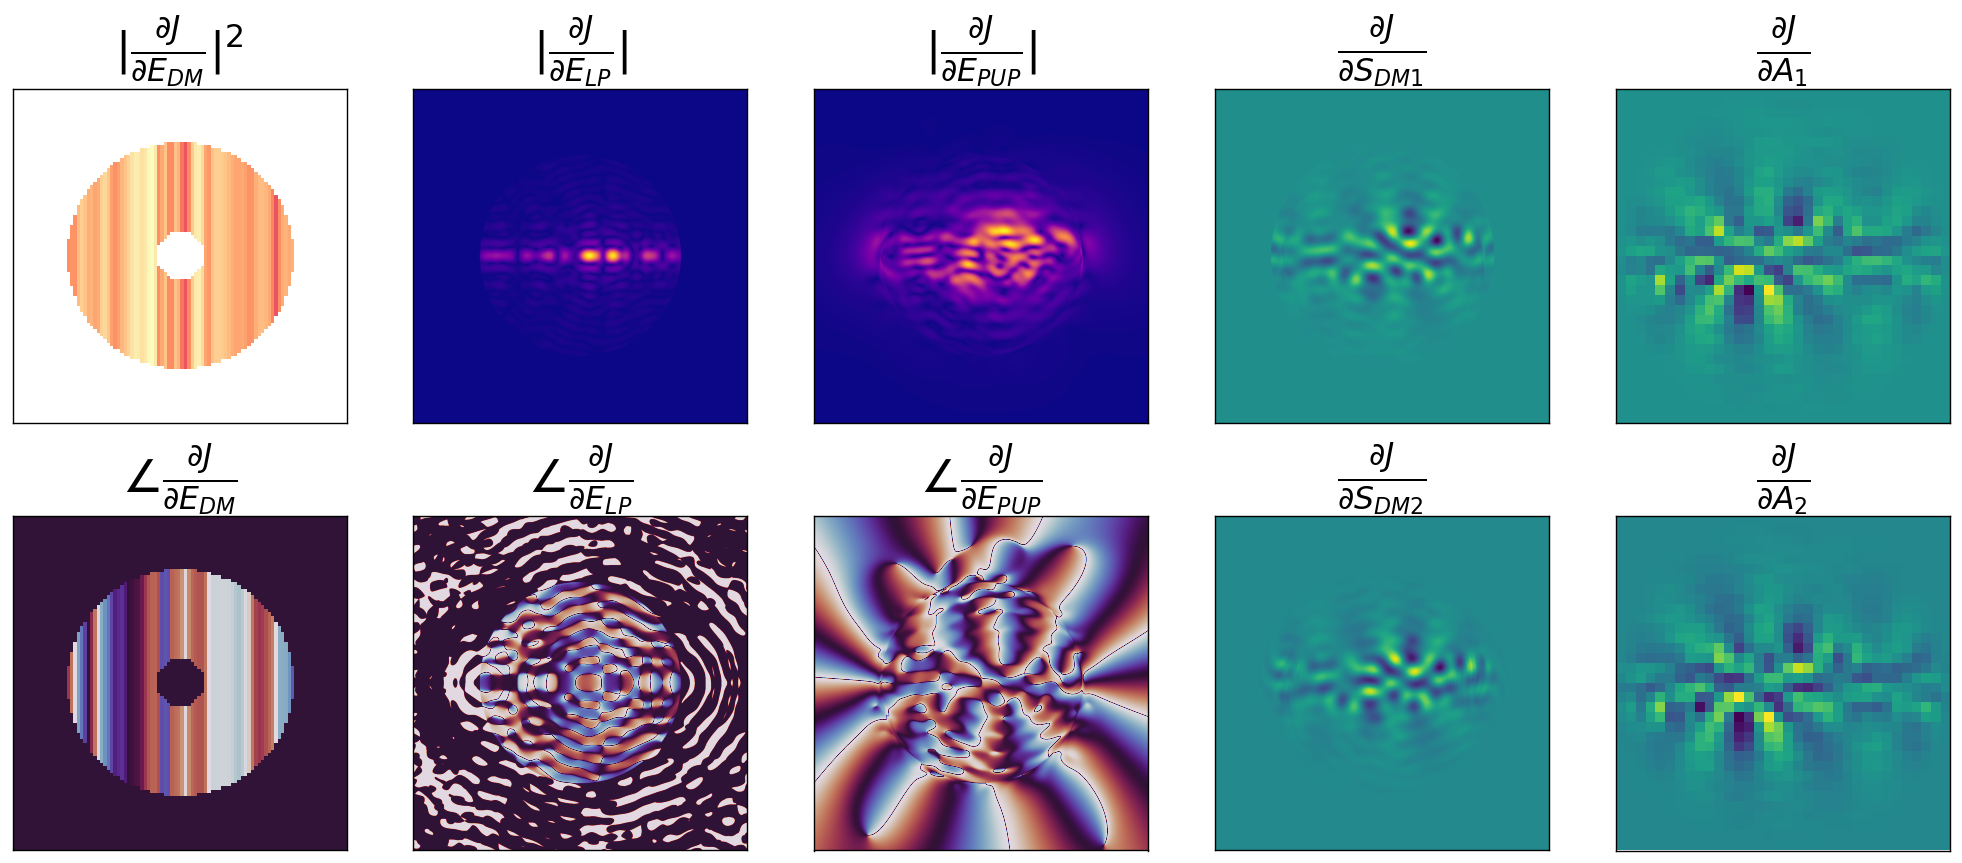

In [16]:
reload(fraunhofer)
from apra_pop_models import imshows
reload(imshows)
current_acts = xp.zeros(M.Nacts)
# current_acts = fits.getdata('example-data/ad_test_acts.fits')

I.set_dm1(fraunhofer.acts_to_command(current_acts[:M.Nacts//2], M.dm_mask))
I.set_dm2(fraunhofer.acts_to_command(current_acts[M.Nacts//2:], M.dm_mask))
E_ab = I.calc_wf()[0] * control_mask
r_cond = 1e-3

E_FP_nom, E_EP, E_DM2P, DM1_PHASOR, DM2_PHASOR = M.forward(current_acts, I.wavelength, use_vortex=True, return_ints=True,)
rmad_vars = {
    'current_acts':current_acts,
    'E_FP_nom':E_FP_nom,
    'E_EP':E_EP,
    'E_DM2P':E_DM2P,
    'DM1_PHASOR':DM1_PHASOR,
    'DM2_PHASOR':DM2_PHASOR,
    'E_ab':E_ab,
    'control_mask':control_mask,
    'wavelength':M.wavelength_c,
    'r_cond':r_cond,
}

del_acts = np.zeros(M.Nacts)
J, dJ_dA = fraunhofer.val_and_grad(
    del_acts, M, rmad_vars,
    verbose=True, 
    # plot=True, 
    fancy_plot=True,
)

dm1_grad = fraunhofer.acts_to_command(dJ_dA[:M.Nacts//2], M.dm_mask)
dm2_grad = fraunhofer.acts_to_command(dJ_dA[M.Nacts//2:], M.dm_mask)
imshow3(dm1_grad, dm2_grad, dm2_grad-dm1_grad)

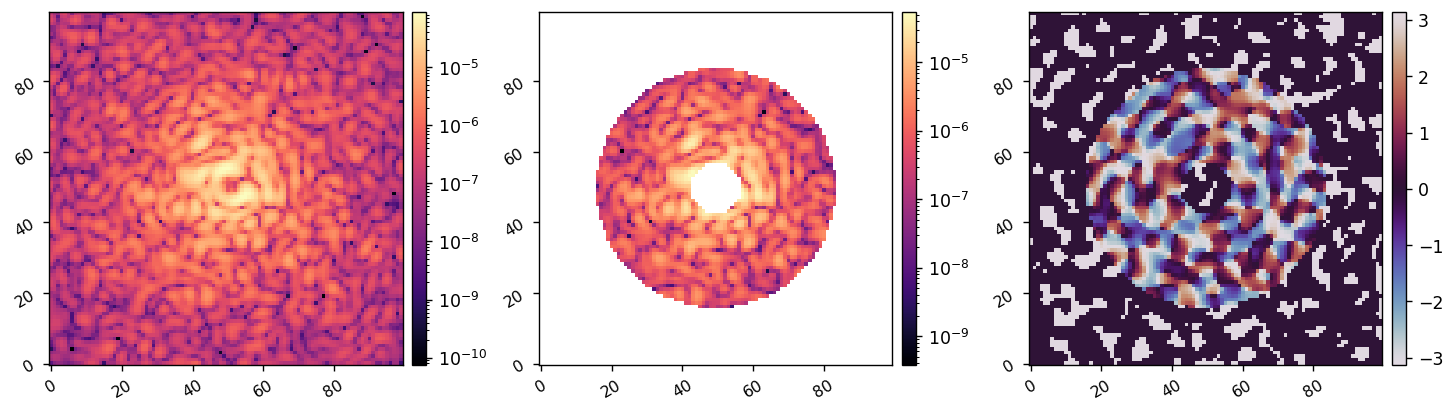

	Cost-function J_delE: 0.009
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.009
	Total cost-function value: 1.000

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1904     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00000D+00    |proj g|=  8.08443D+06


 This problem is unconstrained.


	Cost-function J_delE: 0.001
	Cost-function J_c: 2366863905.325
	Cost-function normalization factor: 0.009
	Total cost-function value: 258547647639.884

	Cost-function J_delE: 0.034
	Cost-function J_c: 5.333
	Cost-function normalization factor: 0.009
	Total cost-function value: 586.247

	Cost-function J_delE: 0.932
	Cost-function J_c: 0.356
	Cost-function normalization factor: 0.009
	Total cost-function value: 140.661

	Cost-function J_delE: 3.537
	Cost-function J_c: 0.024
	Cost-function normalization factor: 0.009
	Total cost-function value: 388.989

	Cost-function J_delE: 0.814
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.009
	Total cost-function value: 88.905

	Cost-function J_delE: 0.003
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.009
	Total cost-function value: 0.314


At iterate    1    f=  3.14075D-01    |proj g|=  2.19522D+06
	Cost-function J_delE: 0.002
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.009
	Total cost-fun

In [ ]:
reload(fraunhofer)

current_acts = xp.zeros(M.Nacts)
# current_acts = fits.getdata('example-data/ad_test_acts.fits')

I.set_dm1(fraunhofer.acts_to_command(current_acts[:M.Nacts//2], M.dm_mask))
I.set_dm2(fraunhofer.acts_to_command(current_acts[M.Nacts//2:], M.dm_mask))
E_ab = I.calc_wf() * control_mask
coro_im = I.snap()
imshow3(coro_im, xp.abs(E_ab)**2, xp.angle(E_ab), lognorm1=True, lognorm2=True, cmap3='twilight')

E_FP_nom, E_EP, E_DM2P, DM1_PHASOR, DM2_PHASOR = M.forward(current_acts, I.wavelength, use_vortex=True, return_ints=True,)

rmad_vars = { 
    'current_acts':current_acts,
    'E_ab':E_ab, 
    'E_FP_nom':E_FP_nom,
    'E_EP':E_EP,
    'E_DM2P':E_DM2P,
    'DM1_PHASOR':DM1_PHASOR,
    'DM2_PHASOR':DM2_PHASOR,
    'control_mask':control_mask,
    'wavelength':I.wavelength,
    'r_cond':1e-3,
}

bfgs_tol = 1e-3
bfgs_opts = {
    'disp':True,
    # 'maxls':50,
    # 'ftol':1e-6,
    # 'gtol':1e-6,
}

del_acts0 = np.zeros(M.Nacts)
res = minimize(fraunhofer.val_and_grad, 
                jac=True, 
                x0=del_acts0,
                args=(M, rmad_vars, True, False), 
                method='L-BFGS-B',
                tol=bfgs_tol,
                options=bfgs_opts,
                )


2.658089214049493e-06 2.1289520255306057e-08


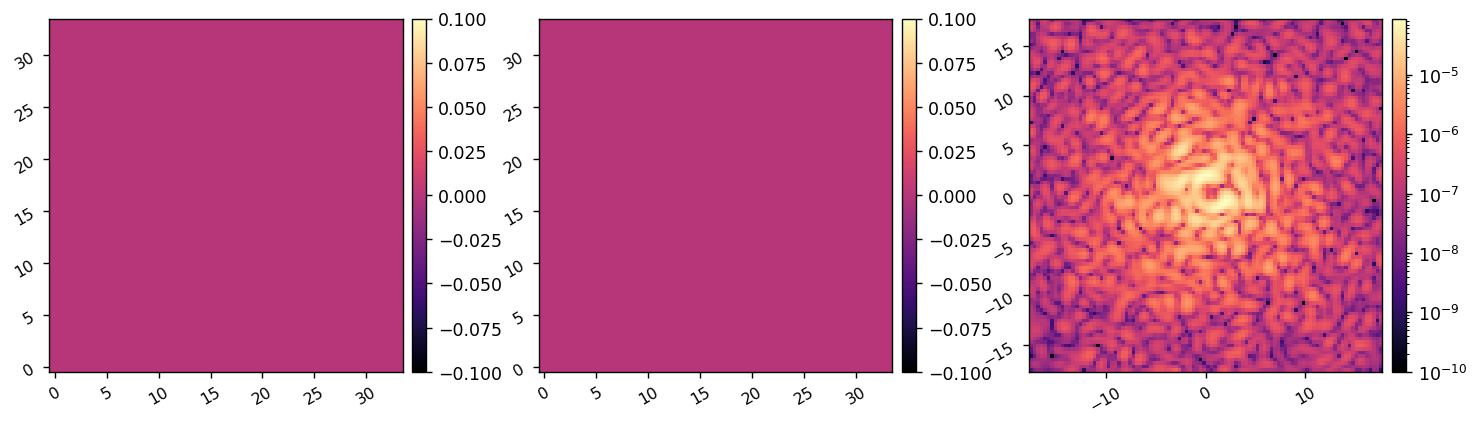

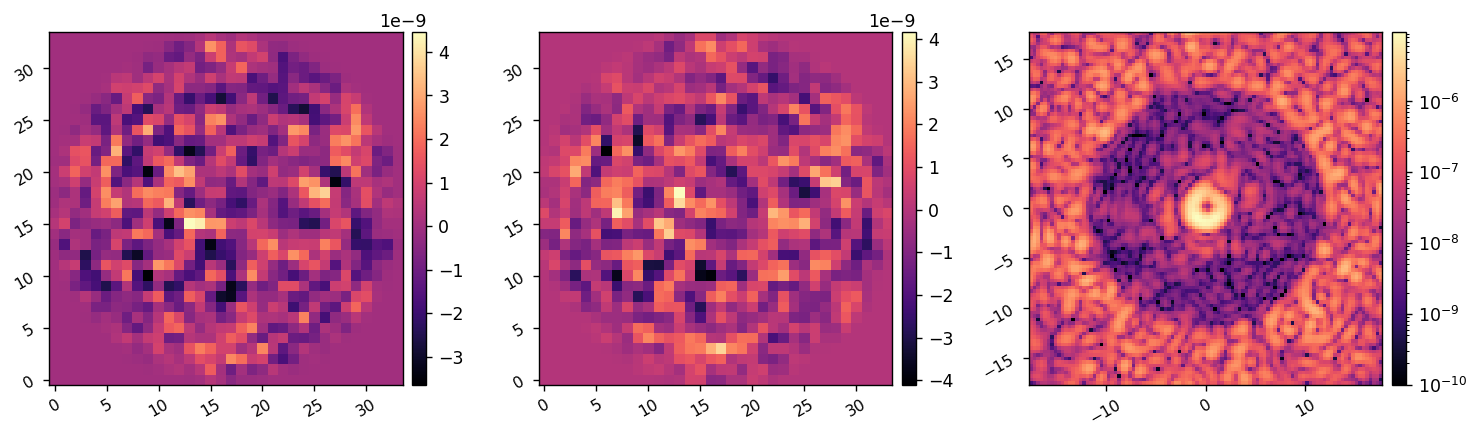

In [ ]:
old_dm1 = fraunhofer.acts_to_command(current_acts[:M.Nacts//2], I.dm_mask)
old_dm2 = fraunhofer.acts_to_command(current_acts[M.Nacts//2:], I.dm_mask)
del_dm1 = fraunhofer.acts_to_command(res.x[:M.Nacts//2], I.dm_mask)
del_dm2 = fraunhofer.acts_to_command(res.x[M.Nacts//2:], I.dm_mask)

I.set_dm1(old_dm1 + del_dm1)
I.set_dm2(old_dm2 + del_dm2)
new_im = I.snap()

print(xp.mean(coro_im[control_mask]), xp.mean(new_im[control_mask]))
imshow3(old_dm1, old_dm2, coro_im, lognorm3=True, pxscl3=I.psf_pixelscale_lamDc, vmin3=1e-10,)
imshow3(del_dm1, del_dm2, new_im, lognorm3=True, pxscl3=I.psf_pixelscale_lamDc, vmin3=1e-10,)

In [ ]:
utils.save_fits('ad_test_acts.fits', res.x)

Saved data to:  ad_test_acts.fits


In [ ]:
I.zero_dms()
data = {
    # 'ref_im':ref_coro_im, 
    'images':[ref_coro_im],
    'efields':[],
    'dm1_commands':[],
    'del_dm1_commands':[],
    'dm2_commands':[],
    'del_dm2_commands':[],
    'reg_conds':[],
    'bfgs_tols':[],
    'pixelscale':I.psf_pixelscale_lamDc,
    'control_mask':control_mask, 
}

Running estimation algorithm ...


Computing EFC command with L-BFGS
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1904     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00000D+00    |proj g|=  8.08443D+06


 This problem is unconstrained.



At iterate    1    f=  4.59368D-01    |proj g|=  5.67089D+06

At iterate    2    f=  1.91328D-01    |proj g|=  1.30627D+06

At iterate    3    f=  1.51675D-01    |proj g|=  9.55339D+05

At iterate    4    f=  1.08504D-01    |proj g|=  8.78303D+05

At iterate    5    f=  6.99378D-02    |proj g|=  7.38671D+05

At iterate    6    f=  6.26608D-02    |proj g|=  1.66679D+06

At iterate    7    f=  3.35555D-02    |proj g|=  4.60969D+05

At iterate    8    f=  2.88729D-02    |proj g|=  2.55532D+05

At iterate    9    f=  2.37570D-02    |proj g|=  2.17372D+05

At iterate   10    f=  2.20384D-02    |proj g|=  8.43264D+05

At iterate   11    f=  1.80344D-02    |proj g|=  2.73225D+05

At iterate   12    f=  1.66491D-02    |proj g|=  1.40130D+05

At iterate   13    f=  1.53667D-02    |proj g|=  2.34878D+05

At iterate   14    f=  1.34287D-02    |proj g|=  3.30802D+05

At iterate   15    f=  1.25832D-02    |proj g|=  2.08477D+05

           * * *

Tit   = total number of iterations
Tnf   = total nu

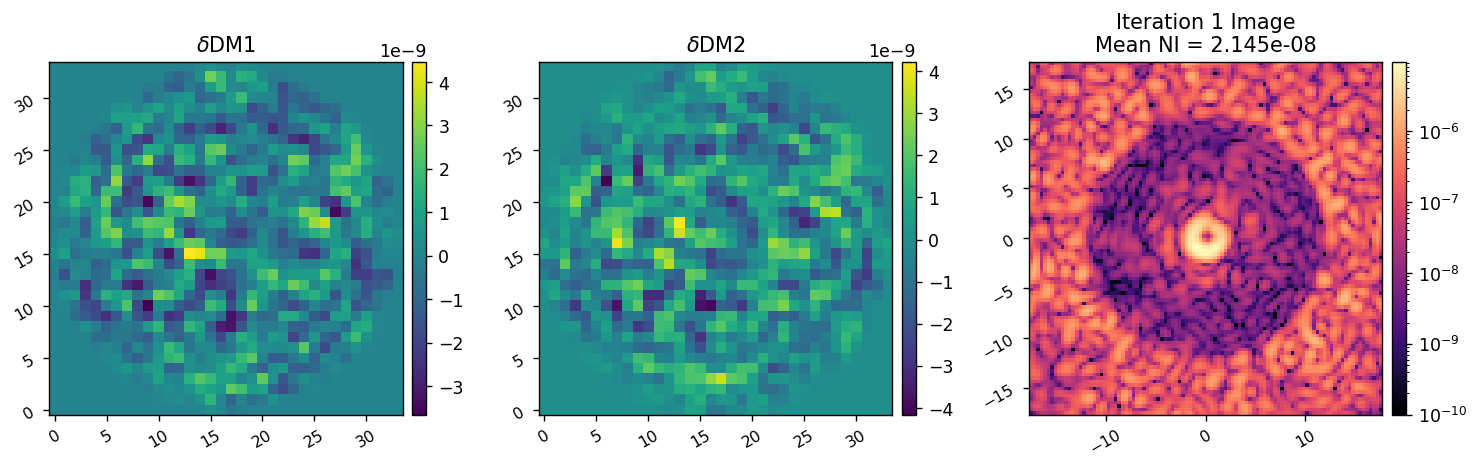

Running estimation algorithm ...
Computing EFC command with L-BFGS
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1904     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00000D+00    |proj g|=  4.77079D+07


 This problem is unconstrained.



At iterate    1    f=  7.56858D-01    |proj g|=  2.99854D+07

At iterate    2    f=  6.80013D-01    |proj g|=  2.05413D+07

At iterate    3    f=  5.91581D-01    |proj g|=  1.37599D+07

At iterate    4    f=  5.19040D-01    |proj g|=  1.71390D+07

At iterate    5    f=  4.50801D-01    |proj g|=  2.35595D+07

At iterate    6    f=  3.95407D-01    |proj g|=  9.87264D+06

At iterate    7    f=  3.65426D-01    |proj g|=  7.73358D+06

At iterate    8    f=  3.28208D-01    |proj g|=  1.00297D+07

At iterate    9    f=  3.15913D-01    |proj g|=  2.46400D+07

At iterate   10    f=  2.76580D-01    |proj g|=  7.97586D+06

At iterate   11    f=  2.56748D-01    |proj g|=  5.84780D+06

At iterate   12    f=  2.38711D-01    |proj g|=  8.28631D+06

At iterate   13    f=  2.12467D-01    |proj g|=  1.47310D+07

At iterate   14    f=  1.98798D-01    |proj g|=  8.55617D+06

At iterate   15    f=  1.86755D-01    |proj g|=  4.96873D+06

At iterate   16    f=  1.80478D-01    |proj g|=  1.20186D+07

At iter

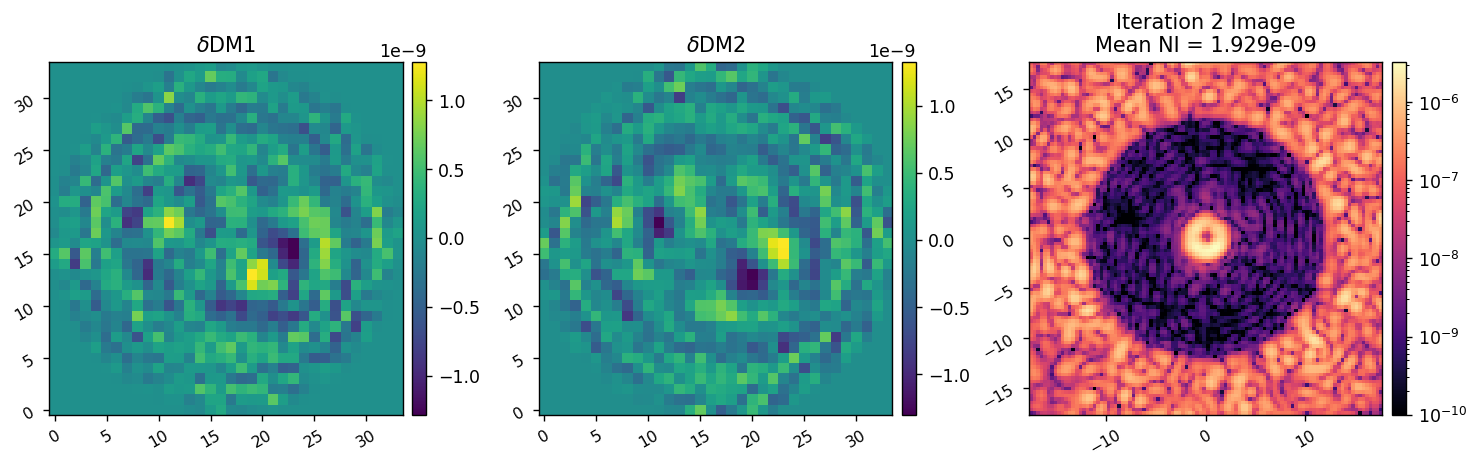

Running estimation algorithm ...
Computing EFC command with L-BFGS
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1904     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00000D+00    |proj g|=  1.27836D+08


 This problem is unconstrained.



At iterate    1    f=  9.09679D-01    |proj g|=  4.79044D+07

At iterate    2    f=  8.80426D-01    |proj g|=  3.85268D+07

At iterate    3    f=  8.08795D-01    |proj g|=  3.72642D+07

At iterate    4    f=  7.99097D-01    |proj g|=  8.13676D+07

At iterate    5    f=  7.61225D-01    |proj g|=  2.54416D+07

At iterate    6    f=  7.39557D-01    |proj g|=  2.04852D+07

At iterate    7    f=  7.12831D-01    |proj g|=  3.09665D+07

At iterate    8    f=  6.75144D-01    |proj g|=  3.27532D+07

At iterate    9    f=  6.18589D-01    |proj g|=  5.54514D+07

At iterate   10    f=  5.88937D-01    |proj g|=  3.90827D+07

At iterate   11    f=  5.57694D-01    |proj g|=  2.29868D+07

At iterate   12    f=  5.32536D-01    |proj g|=  2.72069D+07

At iterate   13    f=  5.16591D-01    |proj g|=  4.16146D+07

At iterate   14    f=  4.99260D-01    |proj g|=  3.32279D+07

At iterate   15    f=  4.84174D-01    |proj g|=  2.40047D+07

At iterate   16    f=  4.73890D-01    |proj g|=  2.82150D+07

At iter

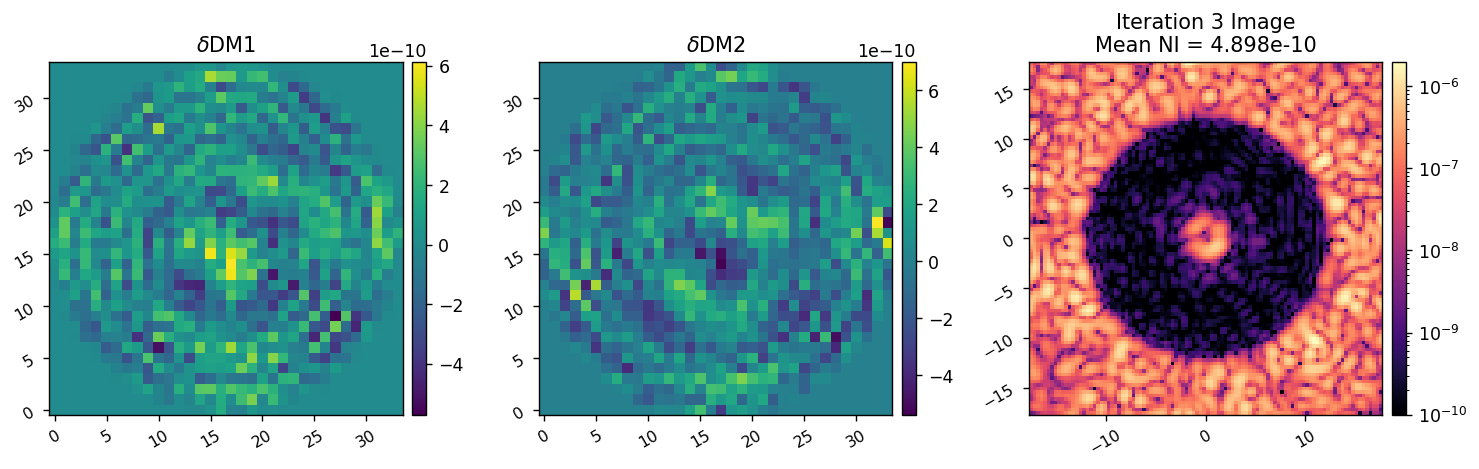

In [ ]:
reload(fraunhofer)
reload(adefc)

r_cond = 1e-2
# r_cond = 1e-3
# r_cond = 1e-4
# r_cond = 1e-5
# r_cond = 1e-6

bfgs_tol = 1e-2
bfgs_tol = 1e-3
# bfgs_tol = 1e-4
# bfgs_tol = 1e-5

bfgs_opts = {
    'disp':True,
    # 'ftol':1e-6,
    # 'gtol':1e-6,
}

data = adefc.run(
    I, 
    M, 
    fraunhofer.val_and_grad, 
    control_mask, 
    data,
    Nitr=3, 
    reg_cond=r_cond,
    bfgs_tol=bfgs_tol,
    bfgs_opts=bfgs_opts,
    gain=1,
)

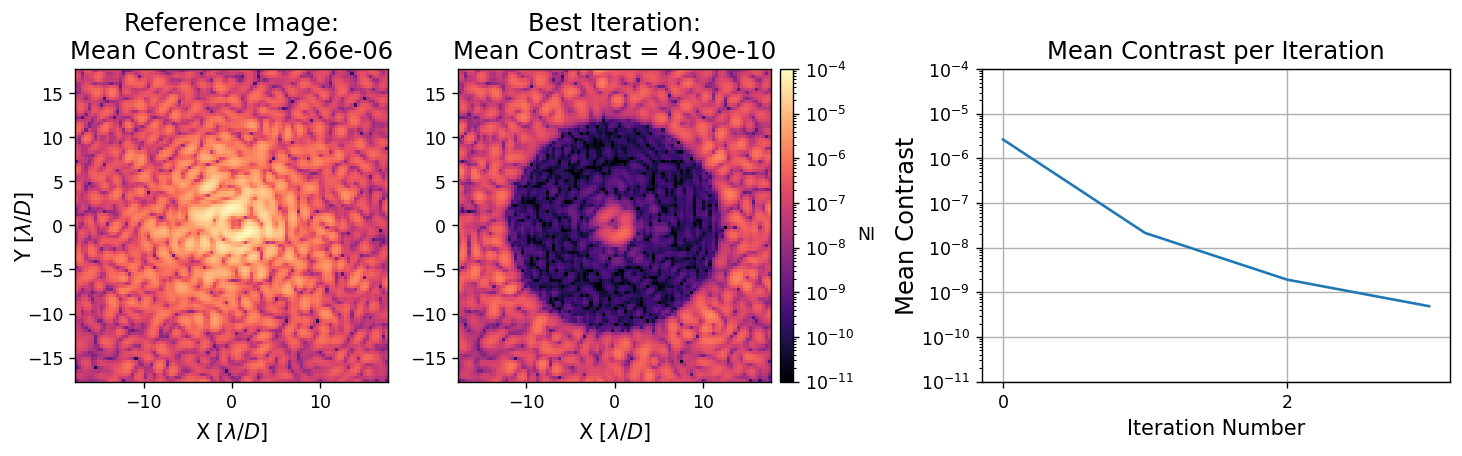

In [ ]:
reload(adefc)
adefc.plot_data(data, vmin=1e-11)